# Курс "Управление рисками"


## Гусев Илья - Домашняя работа №7: Прогнозирование поведения клиентов

### Часть 1. Кривые DEF rate и DLQ ratio

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

from scipy.optimize import minimize

import pickle

## Подготовка данных

Выгружаем прежде обученную модель для предсказания PD, а также все необходимые данные.

In [2]:
GB_Classifier = pickle.load(open('PD_GradBoost.pkl', 'rb'))

In [3]:
df_scores = pd.read_csv('data_scores_and_features.csv')

In [4]:
df_scores.head()

,user_id,pd,x_score,max_util,avg_util,credits_2y,credits_4y,bad_history_credits_flg,other_util,avg_term,min_term,avg_limit_mortgage,min_limit_mfo,close_balance_amt,soc_dem_score,max_delq_cnt,avg_active_time,last_credit_time_years
0,5269,"0,0390977205391442","0,127199135674353",0.000000,0.000000,0.0,0.0,1,0.210959,-7.111111,-57.0,-1.0,-1.0,0.0,-5.834056,0.0,-1.0,0.0
1,157747,"0,00298839119397661","0,624327037460113",0.000000,0.000000,0.0,0.0,1,0.200141,190.714286,5.0,3545000.0,-1.0,39646.0,-7.996644,0.0,170.0,0.0
2,112119,"0,0634189586034202","0,166025075663731",0.906661,0.777738,0.0,0.0,1,0.887264,19.000000,16.0,-1.0,-1.0,9087.0,-4.420416,0.0,21.0,1.0
3,131663,"0,0538517590370807","0,097733043837605",1.003618,0.381491,1.0,1.0,1,0.371895,138.500000,12.0,-1.0,-1.0,1262802.0,-6.395523,0.0,60.0,2.0
4,122778,"0,0462823278081679","0,458679924133087",0.900334,0.347921,0.0,0.0,0,0.366521,8.200000,3.0,-1.0,-1.0,10801.0,-6.920208,0.0,16.0,2.0


Получим PD с помощью своей модели, для этого преобразуем некоторые признаки в соответствии с тем, как обучалась модель.

In [5]:
df_scores.isna().any()

user_id                    False
pd                         False
x_score                    False
max_util                    True
avg_util                    True
credits_2y                  True
credits_4y                  True
bad_history_credits_flg    False
other_util                  True
avg_term                    True
min_term                    True
avg_limit_mortgage          True
min_limit_mfo               True
close_balance_amt           True
soc_dem_score               True
max_delq_cnt                True
avg_active_time             True
last_credit_time_years      True
dtype: bool

In [6]:
df_scores[df_scores['max_util'].isna()]

,user_id,pd,x_score,max_util,avg_util,credits_2y,credits_4y,bad_history_credits_flg,other_util,avg_term,min_term,avg_limit_mortgage,min_limit_mfo,close_balance_amt,soc_dem_score,max_delq_cnt,avg_active_time,last_credit_time_years
32506,109960,"0,05948359620167","0,156460915425629",NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68471,131144,"0,0332276121148728","0,156460915425629",NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93755,143142,"0,0329492942347252","0,156460915425629",NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_scores.drop(index=df_scores[df_scores['max_util'].isna()].index, axis=0).isna().any()

user_id                    False
pd                         False
x_score                    False
max_util                   False
avg_util                   False
credits_2y                 False
credits_4y                 False
bad_history_credits_flg    False
other_util                 False
avg_term                    True
min_term                    True
avg_limit_mortgage         False
min_limit_mfo              False
close_balance_amt          False
soc_dem_score              False
max_delq_cnt               False
avg_active_time             True
last_credit_time_years     False
dtype: bool

In [8]:
df_scores.drop(index=df_scores[df_scores['max_util'].isna()].index, axis=0, inplace=True)

Необходимо заполнить пропуски и ограничить avg_term, avg_active_time; ограничить max_util, last_credit_time_years; (домножить close_balance_amt и avg_limit_mortgage на (-1) - понятно, что смысла в этом нет, но для аккуратности, так было сделано в прошлом дз)

In [9]:
df_scores['avg_term'].fillna(96.2519, inplace=True)
df_scores['avg_term'].clip(lower=0, upper=500, inplace=True)

df_scores['avg_active_time'].fillna(144.0394, inplace=True)
df_scores['avg_active_time'].clip(lower=0, inplace=True)

df_scores['close_balance_amt*(-1)'] = df_scores['close_balance_amt'] * (-1)
df_scores['avg_limit_mortgage*(-1)'] = df_scores['avg_limit_mortgage'] * (-1)

df_scores['max_util_clipped'] = df_scores['max_util'].clip(upper=3.0124051595006756)
df_scores['last_credit_time_years_clipped'] = df_scores['last_credit_time_years'].clip(upper=10)

Признаки, участвующие в модели.

In [10]:
features_gb = ['max_util_clipped', 'last_credit_time_years_clipped',
               'soc_dem_score', 'avg_util', 'other_util', 'credits_4y', 'credits_2y', 'min_limit_mfo',
               'close_balance_amt*(-1)', 'avg_limit_mortgage*(-1)', 'avg_active_time']

Значения PD, полученные с помощью своей модели.

In [11]:
df_scores['PD'] = GB_Classifier.predict_proba(df_scores[features_gb])[:, 1]

In [12]:
df_scores = df_scores[['user_id', 'x_score', 'PD']]

In [13]:
df_scores

,user_id,x_score,PD
0,5269,"0,127199135674353",0.039579
1,157747,"0,624327037460113",0.020394
2,112119,"0,166025075663731",0.070086
3,131663,"0,097733043837605",0.144427
4,122778,"0,458679924133087",0.052149
...,...,...,...
104815,39195,"0,361920722803616",0.061180
104816,113647,"0,196730822359862",0.124699
104817,158552,"0,22213306861111",0.049197
104818,35628,"0,247078869022331",0.080854


In [14]:
df_scores['x_score'] = df_scores['x_score'].apply(lambda x: float(x.replace(',', '.')))

In [15]:
df_v1 = pd.read_csv('data_vintages1.csv')
df_v2 = pd.read_csv('data_vintages2.csv')

C:\Users\user\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [16]:
df_v1.head()

,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg
0,127336.0,19,2019-07-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0
1,35907.0,16,2019-04-01,2019-04-01,1,0,0,0,1,0.0,0.0,0.0
2,45228.0,21,2019-05-01,2019-04-01,0,0,0,1,0,0.0,0.0,1.0
3,39035.0,23,2019-07-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0
4,130780.0,19,2019-08-01,2019-07-01,1,0,0,0,1,0.0,0.0,0.0


In [17]:
df_v1.dropna(inplace=True)

In [18]:
df_v1['user_id'] = df_v1['user_id'].apply(int)

In [19]:
df_v2.head()

,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg
0,2558,6,2019-02-01,2019-01-01,0,0,0,1,0,0,0,1.0
1,128342,2,2019-08-01,2019-07-01,0,0,0,1,0,0,0,1.0
2,177443,22,2019-11-01,2019-10-01,1,0,0,0,1,0,0,0.0
3,189513,12,2020-02-01,2020-01-01,0,0,0,1,0,0,0,1.0
4,142249,8,2019-09-01,2019-07-01,1,0,0,0,1,0,0,0.0


In [20]:
df_v2.dropna(inplace=True)

In [21]:
df_scores = df_scores.sort_values(['PD'], ignore_index=True)
df_scores['pd_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0] // 3), 2)
print(df_scores.groupby(['pd_bucket'])['PD'].mean())

df_scores = df_scores.sort_values(['x_score'], ignore_index=True)
df_scores['x_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0] // 3), 2)
print(df_scores.groupby(['x_bucket'])['x_score'].mean())

pd_bucket
0    0.026339
1    0.050863
2    0.103031
Name: PD, dtype: float64
x_bucket
0    0.133271
1    0.220842
2    0.379455
Name: x_score, dtype: float64


In [22]:
df = pd.concat([df_v1, df_v2], axis=0, ignore_index=True)

In [23]:
df = df.merge(df_scores[['user_id', 'pd_bucket', 'x_bucket', 'PD', 'x_score']], how='left', on='user_id').dropna()

In [24]:
df['statement_num'] = df['statement_num'].apply(int)

In [25]:
df.head()

,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg,pd_bucket,x_bucket,PD,x_score
0,127336,19,2019-07-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0,2.0,2.0,0.073996,0.469410
1,35907,16,2019-04-01,2019-04-01,1,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0.063167,0.157215
2,45228,21,2019-05-01,2019-04-01,0,0,0,1,0,0.0,0.0,1.0,1.0,2.0,0.059393,0.469583
3,39035,23,2019-07-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0,0.0,1.0,0.035075,0.210896
4,130780,19,2019-08-01,2019-07-01,1,0,0,0,1,0.0,0.0,0.0,1.0,1.0,0.049574,0.269492


## DEF ratio

In [26]:
default_ratio_data = (df.groupby(["gen_quarter_dt", "statement_num"])     # группировка по поколению и месяцу жизни клиента
        .agg({"def_flg":np.mean})                                         # считаем средний уровень дефолта
        .rename(columns = {"def_flg": 'default_ratio'})                   # переименовываем столбец со средними значениями
        .unstack('gen_quarter_dt'))                                       # разворачиваем таблицу, столбцы теперь поколения
default_ratio_data

default_ratio                                            
gen_quarter_dt    2019-01-01 2019-04-01 2019-07-01 2019-10-01 2020-01-01
statement_num                                                           
1                   0.000000   0.000000   0.000000   0.000000   0.000000
2                   0.000000   0.000000   0.000000   0.000000   0.000000
3                   0.000000   0.000000   0.000000   0.000000   0.000000
4                   0.024515   0.023656   0.023029   0.020735   0.021470
5                   0.029763   0.028039   0.027167   0.024009   0.025835
6                   0.035068   0.033950   0.031752   0.028419   0.030846
7                   0.042266   0.040768   0.037933   0.032965   0.036310
8                   0.047364   0.045390   0.042546   0.037677   0.040266
9                   0.052514   0.051125   0.048318   0.042310   0.044286
10                  0.059204   0.056813   0.053696   0.047770   0.049649
11                  0.065072   0.062304   0.060560   0.051110   0.054473
12                  0.068689   0.068810   0.066634   0.053543   0.060361
13                  0.072839   0.074930   0.072001   0.057896   0.065103
14                  0.079746   0.082456   0.076588   0.061854   0.068772
15                  0.086588   0.088129   0.079865   0.065792   0.071381
16                  0.091559   0.093412   0.084606   0.069421   0.074247
17                  0.097490   0.097382   0.089293   0.072053   0.078469
18                  0.102767   0.101596   0.093858   0.075218   0.079804
19                  0.107000   0.105916   0.097626   0.078179   0.082799
20                  0.111247   0.110802   0.101652   0.080989   0.085351
21                  0.114579   0.115235   0.104803   0.082920   0.087420
22                  0.119117   0.119536   0.107893   0.084556   0.089480
23                  0.121867   0.123303   0.110588   0.085772   0.091629
24                  0.125836   0.126356   0.112760   0.087645   0.093303

In [27]:
def plot_default_ratio_by_generation(df):
    return (df.groupby(["gen_quarter_dt", "statement_num"])
            .agg({"def_flg":np.mean})
            .rename(columns = {"def_flg": 'default_ratio'})
            .unstack('gen_quarter_dt')
            ['default_ratio']
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))

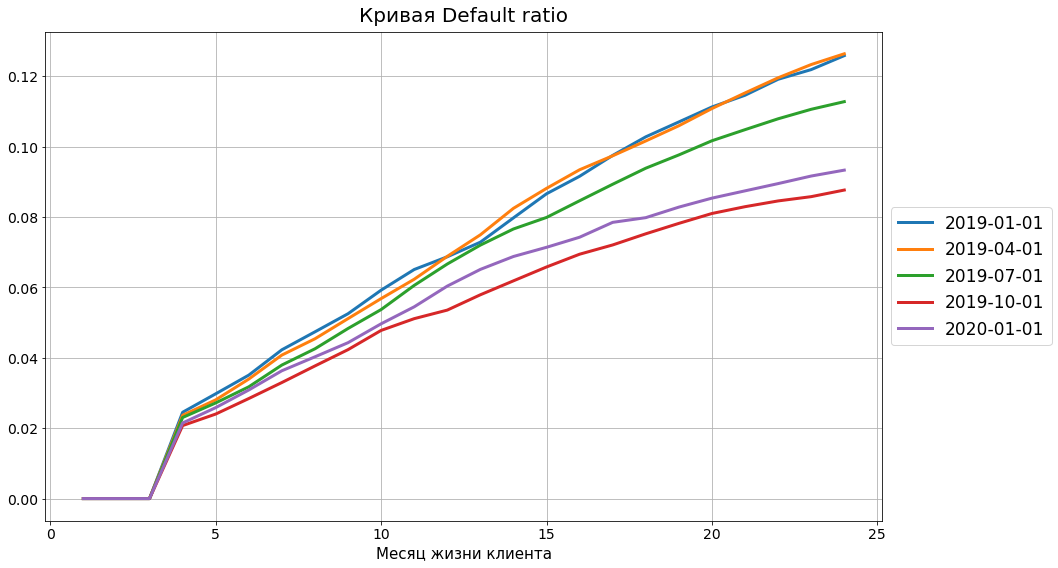

In [28]:
plot_default_ratio_by_generation(df)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Default ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Посмотрим, какая переменная лучше делит кривые.

In [29]:
def plot_default_ratio_by_bucket(df, bucket):
    return (df.query(''' gen_quarter_dt == '2019-01-01' ''')
            .groupby([bucket, "statement_num"])
            .agg({"def_flg":np.mean})
            .rename(columns = {"def_flg": 'default_ratio'})
            .unstack(bucket)
            ['default_ratio']
            .plot(ax=None, figsize=(10, 6), grid=True, lw = 3))

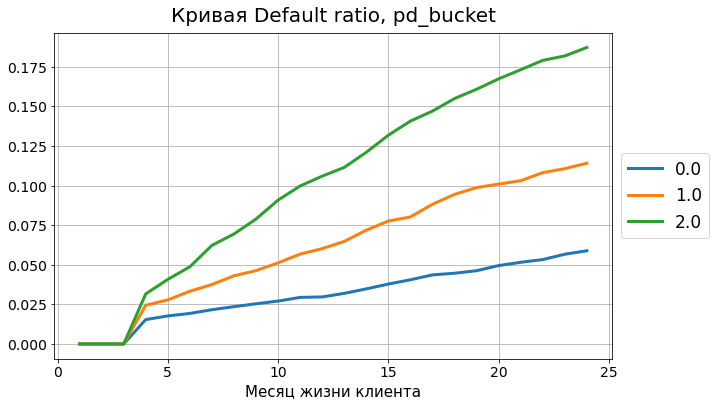

In [30]:
plot_default_ratio_by_bucket(df, 'pd_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Default ratio, pd_bucket", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

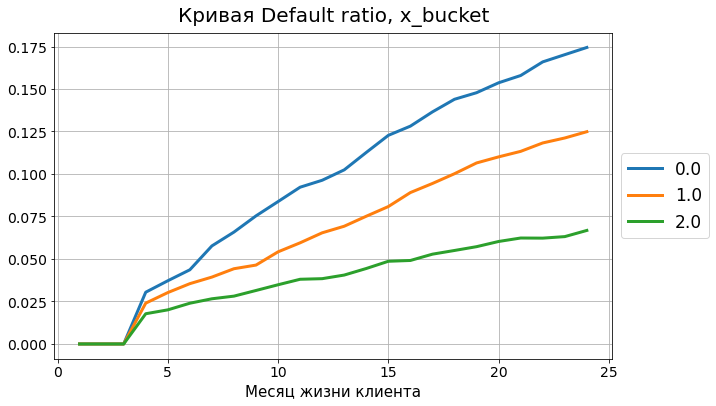

In [31]:
plot_default_ratio_by_bucket(df, 'x_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Default ratio, x_bucket", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Разделение по PD получилось немного лучше, чем по x_score.

Для разделения выберем PD.

##### Анализ поколений.

In [32]:
def plot_distribution(df, bucket):
    return pd.pivot_table(df, index=[bucket], columns='gen_quarter_dt',
                values="user_id",
                aggfunc=np.count_nonzero, fill_value=0)\
               .T\
               .plot(kind='bar', stacked=True, figsize=(15, 9))                    

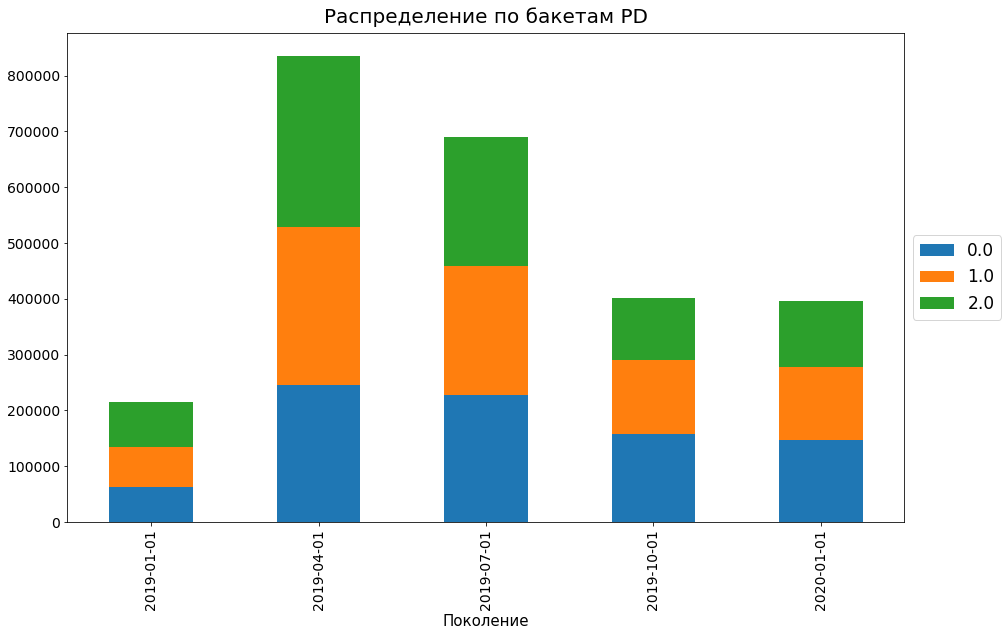

In [33]:
plot_distribution(df, 'pd_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Распределение по бакетам PD", size=20, verticalalignment='bottom')
plt.xlabel("Поколение", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Во всех поколениях достаточно данных - ничего удалять не будем.

## DEF rate

In [34]:
default_rate_data = df.eval('def_new_flg = def_flg * prev_act_flg', inplace=False)\
    .groupby(["gen_quarter_dt", 'pd_bucket', "statement_num"])\
    .agg({"def_new_flg":np.sum, "prev_act_flg":np.sum, "user_id":np.count_nonzero})\
    .rename(columns = ({"def_new_flg":'def_cnt', "prev_act_flg":'prev_act_cnt', "user_id":"cnt"}))\
    .eval('default_rate = def_cnt / prev_act_cnt', inplace=False)
default_rate_data

def_cnt  prev_act_cnt   cnt  \
gen_quarter_dt pd_bucket statement_num                                
2019-01-01     0.0       1                  0.0        2601.0  2601   
                         2                  0.0        2430.0  2596   
                         3                  0.0        2336.0  2596   
                         4                 40.0        2237.0  2600   
                         5                  5.0        2100.0  2599   
...                                         ...           ...   ...   
2020-01-01     2.0       20                28.0        1899.0  4929   
                         21                19.0        1788.0  4931   
                         22                22.0        1702.0  4951   
                         23                14.0        1615.0  4958   
                         24                19.0        1525.0  4927   

                                        default_rate  
gen_quarter_dt pd_bucket statement_num                
2019-01-01     0.0       1                  0.000000  
                         2                  0.000000  
                         3                  0.000000  
                         4                  0.017881  
                         5                  0.002381  
...                                              ...  
2020-01-01     2.0       20                 0.014745  
                         21                 0.010626  
                         22                 0.012926  
                         23                 0.008669  
                         24                 0.012459  

[360 rows x 4 columns]

In [35]:
def plot_default_rate_by_generation(pd_bucket):
    cur_df = default_rate_data.query('pd_bucket == ' + str(pd_bucket))
    (cur_df.unstack('gen_quarter_dt')
            ['default_rate']
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая Default rate, pd_bucket = " + str(pd_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

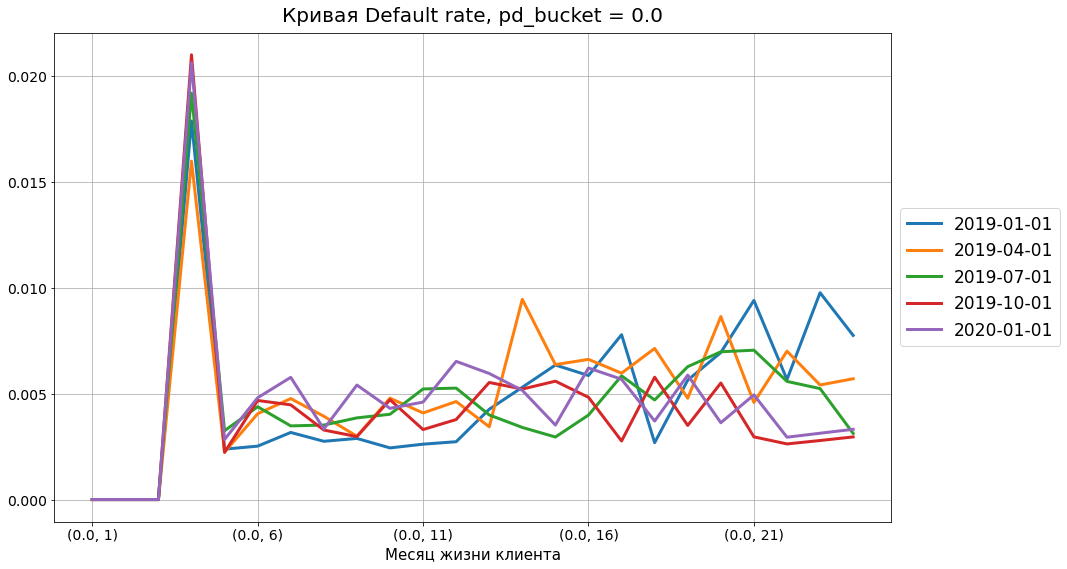

In [36]:
plot_default_rate_by_generation(0.0)

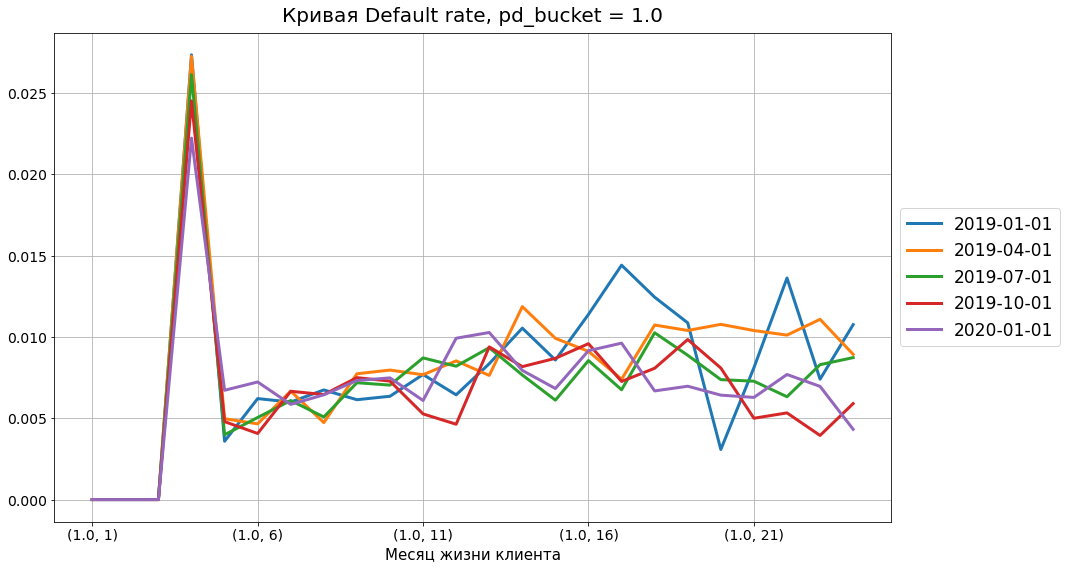

In [37]:
plot_default_rate_by_generation(1.0)

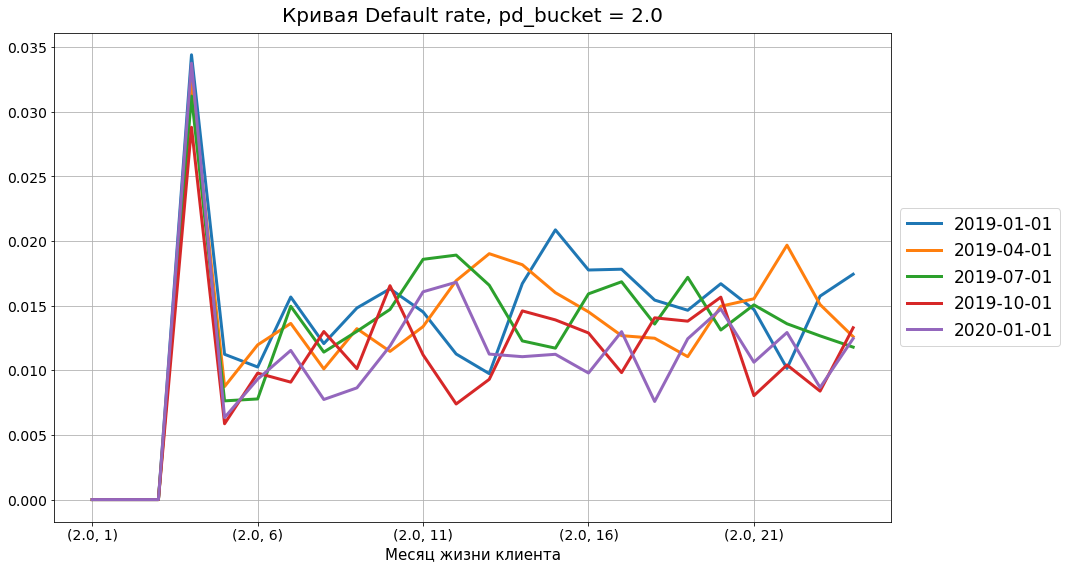

In [38]:
plot_default_rate_by_generation(2.0)

Поколение января 2019 года вносит шум в бакет 1. Удалим его из рассмотрения в этом бакете.

In [39]:
exception_query = ''' ~((gen_quarter_dt == '2019-01-01') & (pd_bucket == 1.0)) '''
default_rate_data.query(exception_query, inplace = True)

Построим среднее по бакетам.

In [40]:
default_rate_mean = default_rate_data.groupby(['statement_num', 'pd_bucket'])\
    .agg({'default_rate':np.mean})\
    .rename(columns = {'default_rate':'Среднее'})

In [41]:
def plot_default_rate_mean(pd_bucket):
    vintages_graph = default_rate_data.query('pd_bucket == ' + str(pd_bucket))\
            .unstack('gen_quarter_dt')\
            ['default_rate']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
    (default_rate_mean.query('pd_bucket == ' + str(pd_bucket))
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    plt.title("Кривая Default rate, pd_bucket = " + str(pd_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

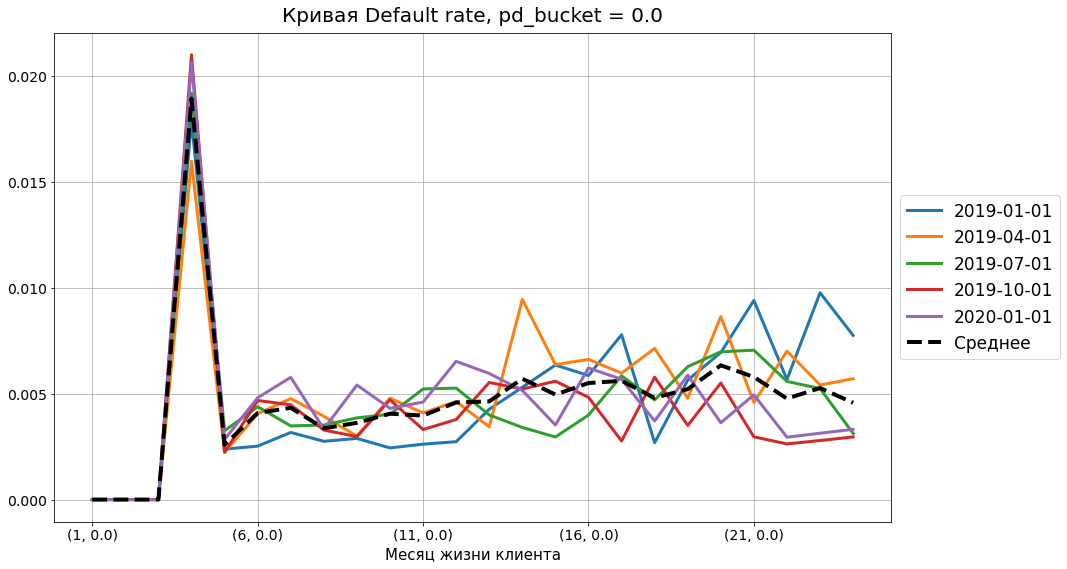

In [42]:
plot_default_rate_mean(0.0)

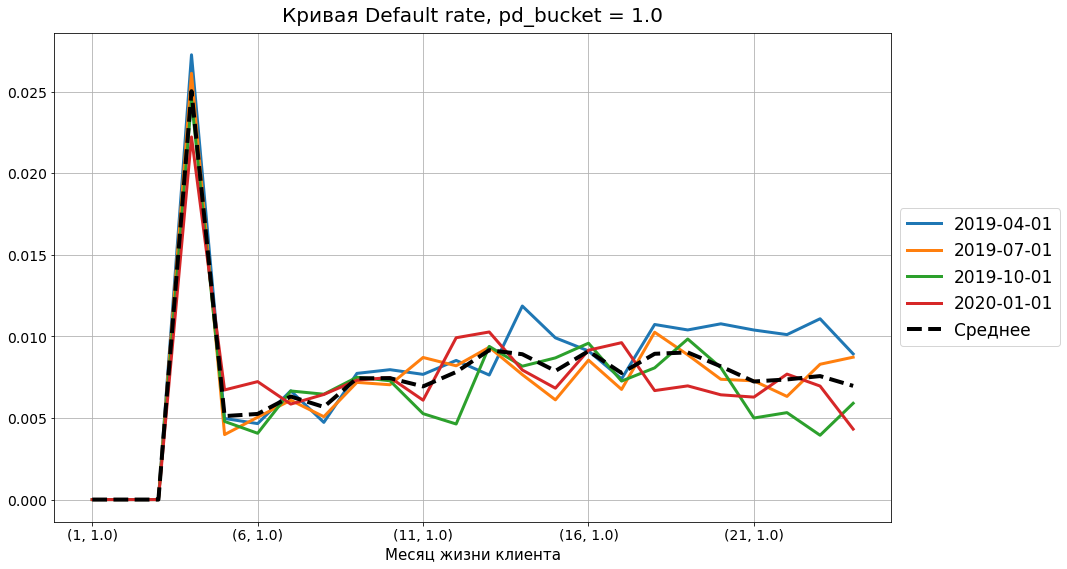

In [43]:
plot_default_rate_mean(1.0)

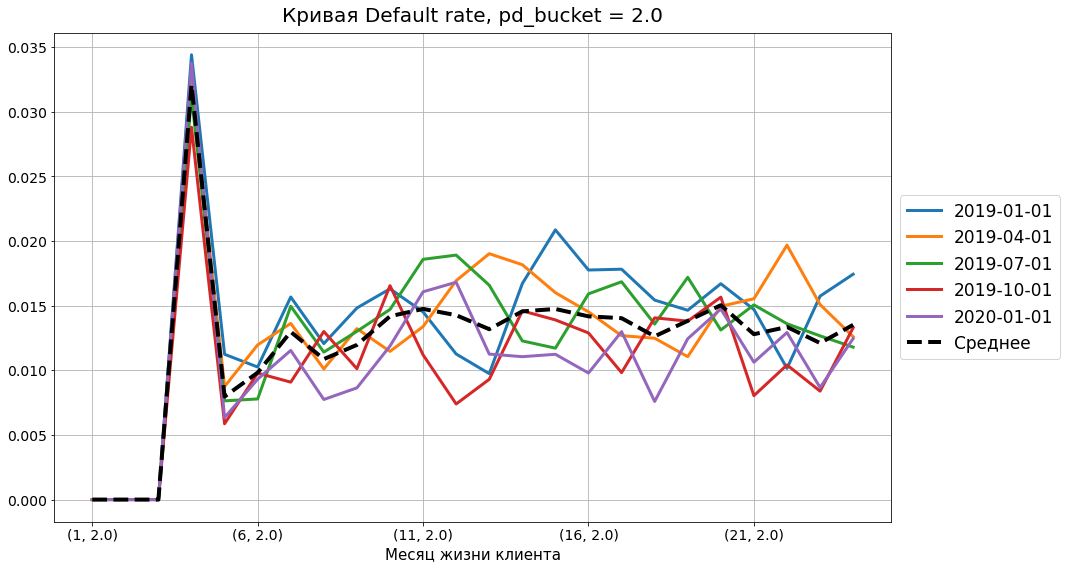

In [44]:
plot_default_rate_mean(2.0)

Сглагим полученные кривые.

In [45]:
def linear_approximation(df, start=1, finish=24):
    df_res = pd.DataFrame(df)
    df_res['Линейная функция'] = df['Среднее']                                                # Копируем средние значения
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], 1)  # Коэффициенты уравнения прямой
    linear_coeff = np.poly1d(linear_coeff)                                                    # Превращаем коэффициенты в функцию
    df_res.loc[start:finish, 'Линейная функция'] = linear_coeff(np.arange(start, finish+1))   # Записываем приближение
    df_res.loc[finish+1:, 'Линейная функция'] = linear_coeff(finish+1)                        # Продолжаем кривую константой
    return df_res

In [46]:
def polynom_approximation(df, start=1, finish=20, degree = 1):
    df_res = pd.DataFrame(df)
    df_res['Полином'] = df['Среднее']                   
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], degree)  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)                                                 
    df_res.loc[start:finish, 'Полином'] = linear_coeff(np.arange(start, finish+1)) 
    df_res.loc[finish+1:, 'Полином'] = linear_coeff(finish+1)                    
    return df_res

In [47]:
def exponential_smoothing(df, start, finish, alpha):
    df_res = pd.DataFrame(df)
    result = [df_res.loc[i,'Среднее'] for i in np.arange(1,start+1)]                              # Начальные значения копируем
    for n in range(start, len(df_res['Среднее'])): 
        result.append(float(alpha * df_res.loc[n + 1, 'Среднее'] + (1 - alpha) * result[n-1]))    # Делаем сглаживание
    df_res['Скользящее среднее'] = result
    return df_res

In [48]:
df_linear = default_rate_mean.query('pd_bucket == 2.0').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 5, 15)

df_polynom = polynom_approximation(df_linear, 5, 24, 2)

df_smooth = exponential_smoothing(df_polynom, 5, 24, 0.5)

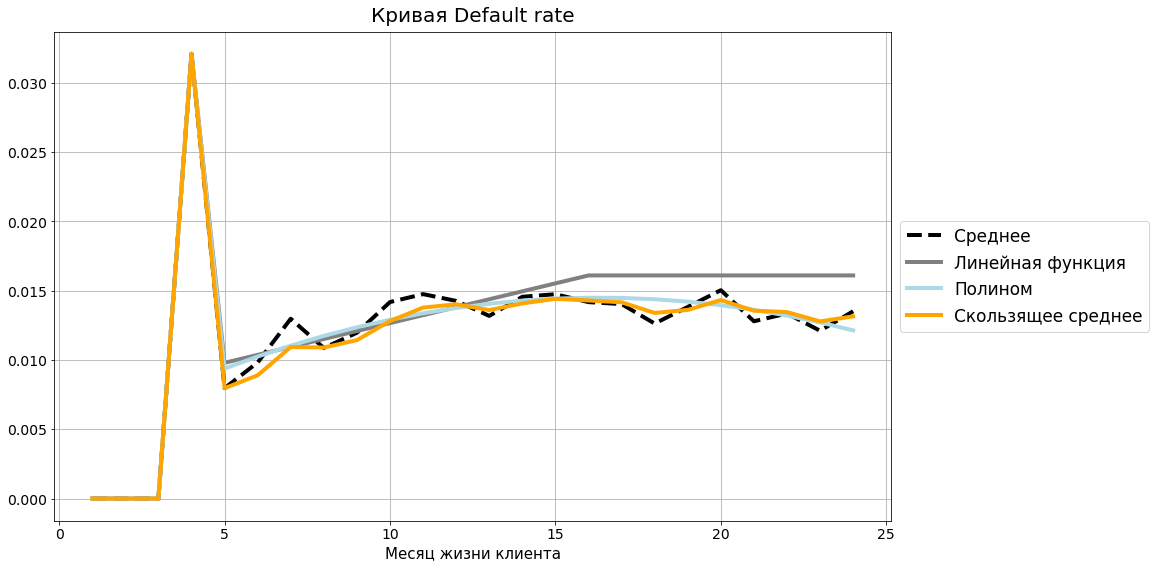

In [49]:
plt.figure(figsize=(15, 9))
df_smooth['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_smooth['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_smooth['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth['Скользящее среднее'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Default rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

- Линейная функция - плохо передает кривую в целом.
- Полином второй степени - хорошо улавливает зависимость.
- Скользящее среднее - слишком подстраивается под данные.

Лучше всего подходит полином второй степени.

In [50]:
df_smooth_result = pd.DataFrame()
buckets  = [0.0, 1.0, 2.0]
for bucket in buckets:
    df_temp = default_rate_mean.query('pd_bucket == ' + str(bucket)).reset_index().set_index(['statement_num'])
    df_smooth_result[str(bucket)] = polynom_approximation(df_temp, 5, 24, 2)['Полином']

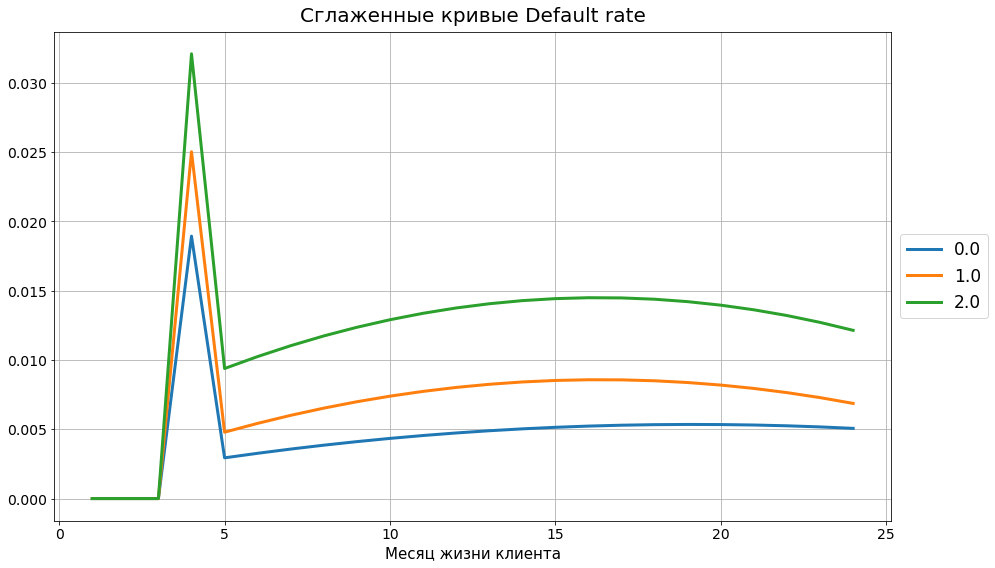

In [51]:
df_smooth_result.plot(figsize=(15, 9), grid=True, lw = 3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Сглаженные кривые Default rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

## DLQ ratio

In [52]:
df = df[df['gen_month_dt'] < '2019-10-01']

In [53]:
def plot_dlq_ratio_by_generation(df):
    return (df.groupby(["gen_month_dt", "statement_num"])
            .agg({"dlq_flg":np.sum, "act_flg":np.sum, "user_id":np.count_nonzero})\
            .rename(columns = ({"dlq_flg":'dlq_cnt', "act_flg":'act_cnt', "user_id":"cnt"}))\
            .eval('dlq_ratio = dlq_cnt / act_cnt', inplace=False)\
            .unstack('gen_month_dt')
            ['dlq_ratio']
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))

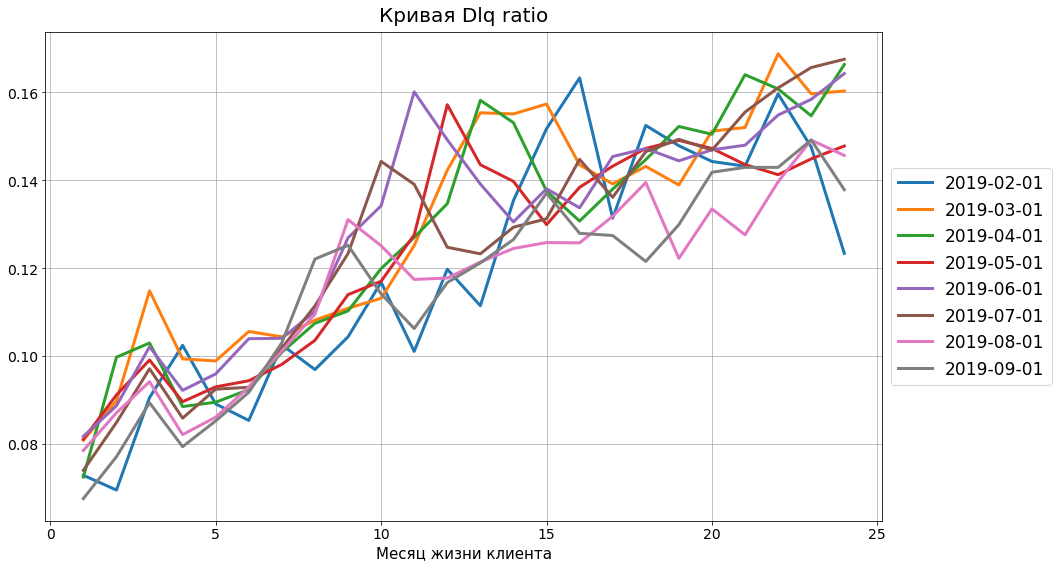

In [54]:
plot_dlq_ratio_by_generation(df)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Разделение.

In [55]:
def plot_dlq_ratio_by_bucket(df, bucket):
    return (df.query(''' gen_month_dt == '2019-04-01' ''')
            .groupby([bucket, "statement_num"])
            .agg({"dlq_flg":np.sum, "act_flg":np.sum, "user_id":np.count_nonzero})\
            .rename(columns = ({"dlq_flg":'dlq_cnt', "act_flg":'act_cnt', "user_id":"cnt"}))\
            .eval('dlq_ratio = dlq_cnt / act_cnt', inplace=False)\
            .unstack(bucket)
            ['dlq_ratio']
            .plot(ax=None, figsize=(10, 6), grid=True, lw = 3))

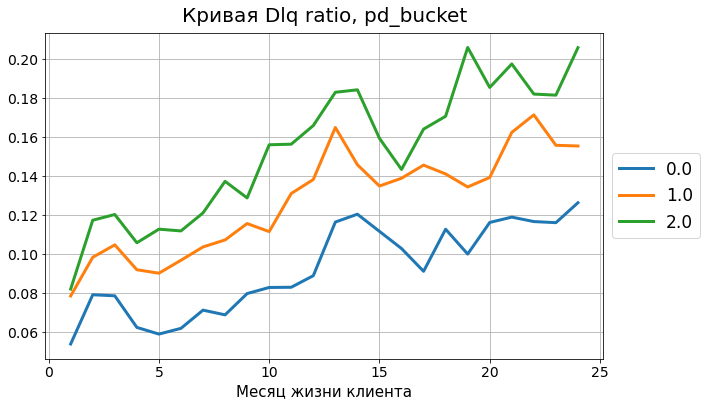

In [56]:
plot_dlq_ratio_by_bucket(df, 'pd_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Dlq ratio, pd_bucket", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

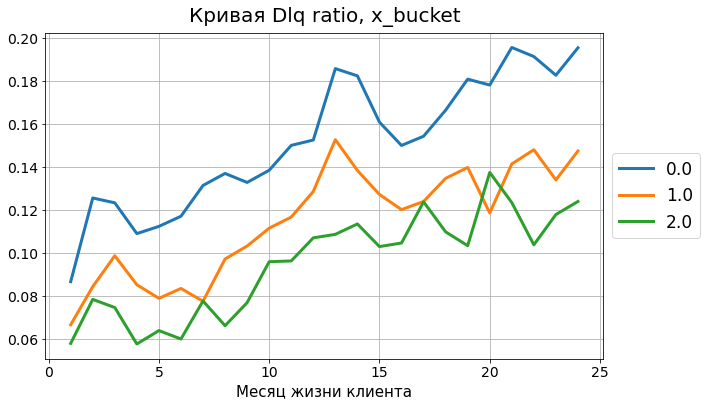

In [57]:
plot_dlq_ratio_by_bucket(df, 'x_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Dlq ratio, x_bucket", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

PD лучше делит кривые. Выберем для разделение PD.

Посмотрим на поколения.

In [58]:
def plot_distribution(df, bucket):
    return pd.pivot_table(df, index=[bucket], columns='gen_month_dt',
                values="user_id",
                aggfunc=np.count_nonzero, fill_value=0)\
               .T\
               .plot(kind='bar', stacked=True, figsize=(15, 9))

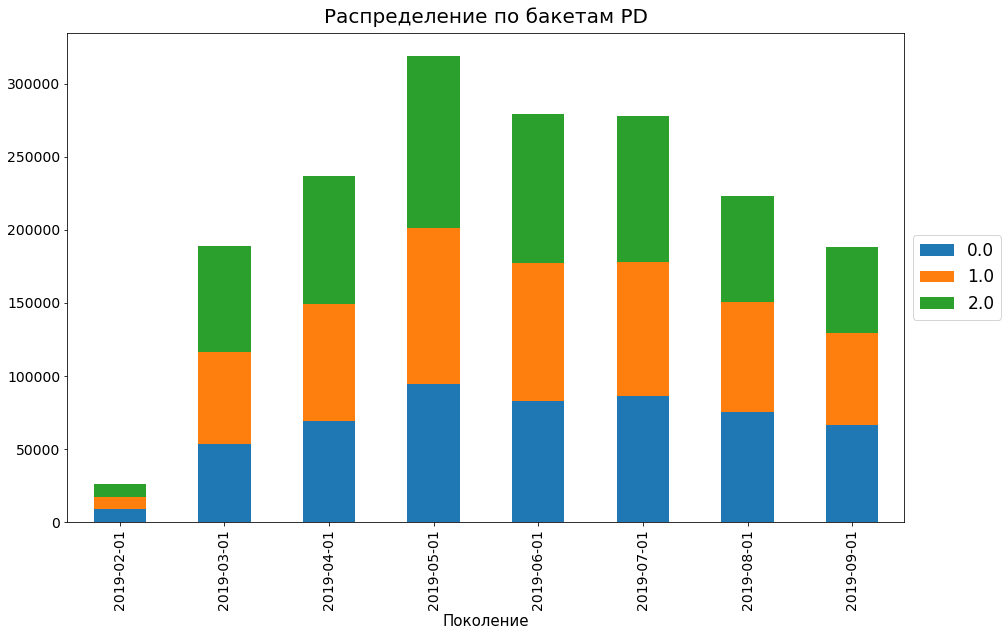

In [59]:
plot_distribution(df, 'pd_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Распределение по бакетам PD", size=20, verticalalignment='bottom')
plt.xlabel("Поколение", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

В поколении февраля 2019 года мало наблюдений - удалим его.

In [60]:
exception_query = ''' ~((gen_month_dt == '2019-02-01')) '''
df.query(exception_query, inplace = True)

Построим кривые по бакетам.

In [61]:
def plot_dlq_ratio_by_generation(data, pd_bucket):
    data_tmp = data.query(''' pd_bucket == @pd_bucket''')\
        .groupby(["gen_month_dt", "statement_num"])\
        .agg({"dlq_flg":np.sum, "act_flg":np.sum, "user_id":np.count_nonzero})\
        .rename(columns = ({"dlq_flg":'dlq_cnt', "act_flg":'act_cnt', "user_id":"cnt"}))\
        .eval('dlq_ratio = dlq_cnt / act_cnt', inplace=False)\
        .unstack('gen_month_dt')['dlq_ratio']\
        .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая Dlq ratio, pd_bucket = " + str(pd_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

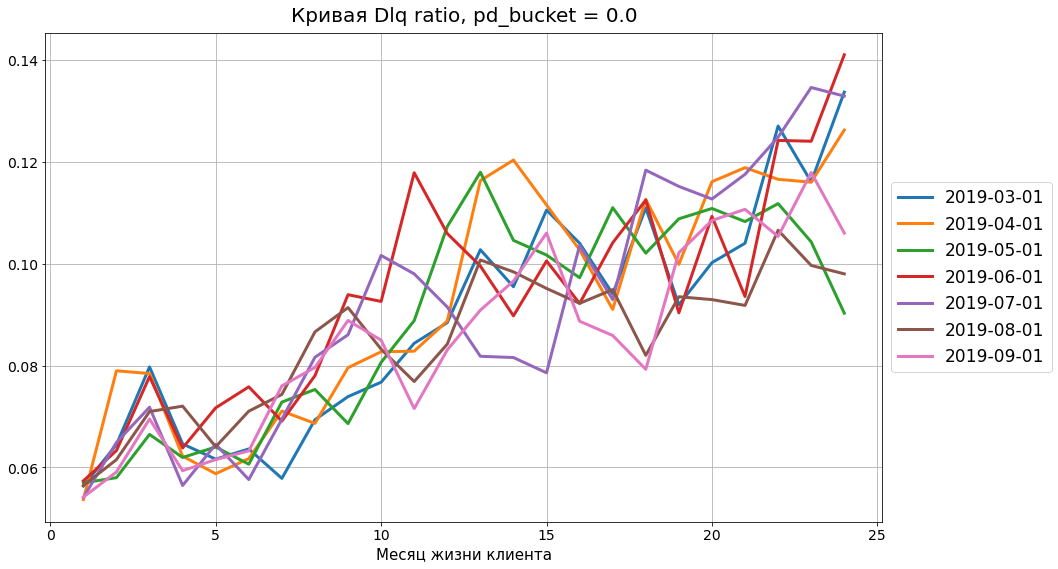

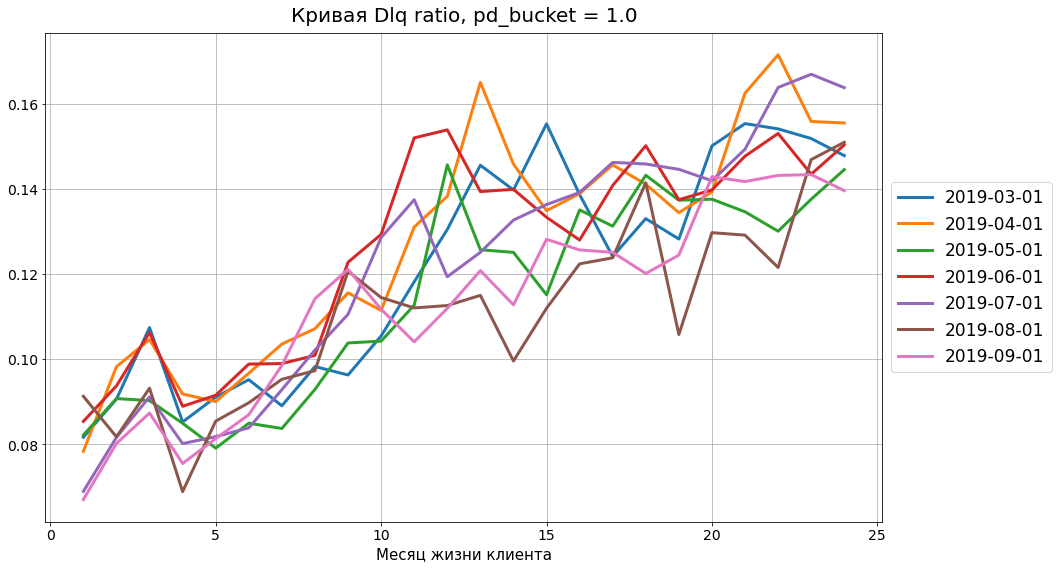

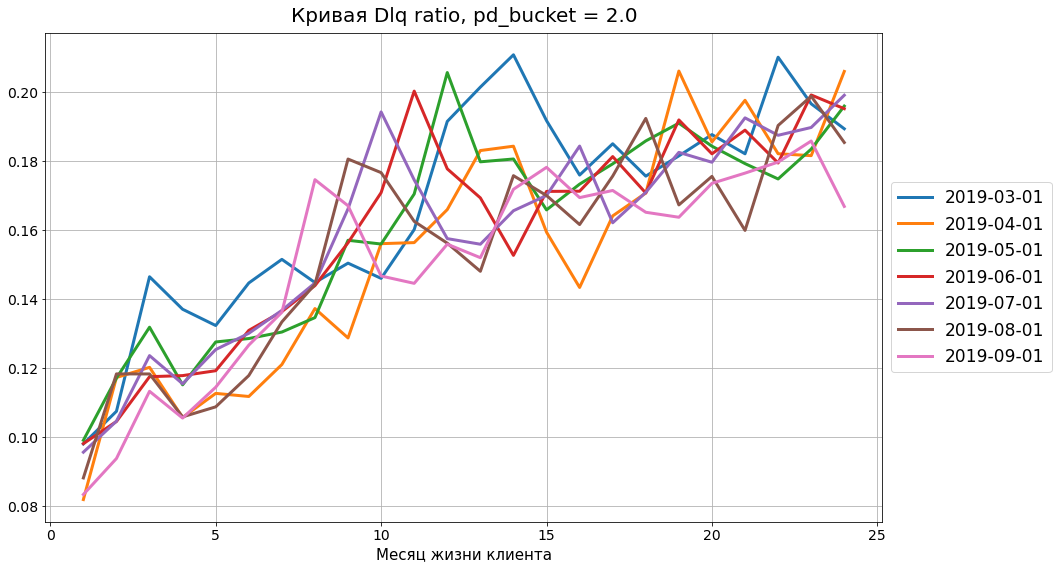

In [62]:
buckets = [0.0, 1.0, 2.0]
for bucket in buckets:
    plot_dlq_ratio_by_generation(df, bucket)

Вычистим от внешнего воздействия.

In [63]:
def curve_build(data, 
                feature, 
                generation = 'generation_quart',
                statement_num = 'statement_num', 
                group_label = '1'):
    
    """Вспомогательная функция для построения разложения в рамках одного бакета
    
    **Аргументы**
    data : pandas.DataFrame
        таблица с данными
    feature: str
        название поля с исследуемой переменной
    generation : datetime
        название поля с поколениями
    where : str
        условие, которым мы ограничиваем выборку
    statement_num : int
        название поля с номером месяца жизни клиента
    group_label : str
        название поля группы
    **Результат**
    dictionary : dict
    """
    
    df_query = data.sort_values([generation, statement_num]).reset_index()

    # Рассчитываем количество поколений и тому подобное
    generation_min = df_query[generation].min()
    gen_cnt = df_query[statement_num].max()

    # Преобразуем Dataframe в набор векторов 
    values = np.array(df_query[feature])
    tab_size = df_query[feature].count()
    st_nums = np.array(df_query[statement_num] - 1)
    dates = np.array([0 for i in range(tab_size)])
    
    for i in range(tab_size):
         dates[i] = df_query.loc[i,generation].year * 12 + df_query.loc[i,generation].month -\
            generation_min.year * 12 - generation_min.month + df_query.loc[i,statement_num] - 1 

    # Определяем функционал, который будем минимизировать

    def r_square(x):
        temp = 0 
        for i in range(tab_size):
            if dates[i] >= 0:
                temp += (values[i] - x[dates[i]] * x[st_nums[i] + gen_cnt])**2
        return temp

    # Задаем callback для отслеживания прогресса минимизации
    def callbackF(Xi):
        global Nfeval
        print('%d  %.6f' % (Nfeval, r_square(Xi)))
        Nfeval += 1

    # Задаем начальное приближение в виде массива с нулевыми значениями

    x0 = np.array([0 for i in range(2*gen_cnt)])                                # Внешние воздействия

    # Численная минимизация

    print('Initial %.6f' % (r_square(x0)))
    res0 = minimize(r_square, x0, tol=1e-6, callback=callbackF, method='Powell', options = {'disp': False, 'maxiter': 1000})

    # Задаем датафрейм с внешними воздействиями
    external_data = pd.DataFrame({'month_dt': [generation_min + pd.DateOffset(months = i) for i in range(gen_cnt)], 
                             group_label: res0.x[:gen_cnt]})

    # Нормируем внешние воздействия таким образом, чтобы в среднем они равнялись единице. 
    ext_mean = external_data[external_data['month_dt'] > generation_min + pd.DateOffset(months = 6)][group_label].mean()
    external_data[group_label] = external_data[group_label] / ext_mean
    
    # И умножаем на полученный коэффициент кривые созревания
    
    maturation_array = np.transpose([res0.x[gen_cnt:2* gen_cnt] * ext_mean]).flatten()
    maturation_data = pd.DataFrame(data = {group_label: maturation_array, \
                                           'statement_num': np.arange(1,maturation_array.size + 1)})

    df_fitted = df_query.merge(right=external_data, on = 'month_dt')
    df_fitted['fitted_feature'] = df_fitted[feature] / df_fitted[group_label]

    # Формируем словарь c итоговыми данными
    res = {'res0': res0,
          'external_data': external_data,
          'maturation_data': maturation_data,
          'df_fitted': df_fitted}
    return res


def decomposition(df, 
                  generation = 'generation_month', 
                  group = 'bucket', 
                  statement_num = 'statement_num', 
                  feature = 'feature', 
                  optimization_query = ''):
    """Винтажи исследуемой переменной по календарному времени
    
    **Аргументы**
    df : pandas.DataFrame
        таблица с данными
    generation : datetime
        название поля с поколениями
    group : str
        название поля с бакетами
    statement_num : int
        название поля с номером выписки
    feature: str
        название поля с исследуемой переменной
    optimization_query: str
        ограничение выборки для оптимизации
    **Результат**
    dictionary : dict
    """

    # Разбираемся со случаем пустых аргументов
 
    if optimization_query == '':
        df_query = pd.DataFrame(df)
    else:
        df_query = df.query(optimization_query)
    
    timedelta = df_query[statement_num].apply(lambda x: pd.DateOffset(months=x-1))
    df_query['month_dt'] = df_query[generation] + timedelta
    
      # Формируем список бакетов
    
    df_query.sort_values(by = [group], inplace = True)
    groups = pd.Series(df_query[group].drop_duplicates())
    
    # Запускаем цикл по бакетам
    i = 0
    for g in groups:
        df_temp = df_query[df_query[group] == g]
        print(group + ' = ' + str(g))
        
        # Строим разложение для одного бакета
        res = curve_build(df_temp, 
                          feature = feature, 
                          generation = generation, 
                          statement_num = statement_num, 
                          group_label = str(g)
                         )
        df_fitted_temp = pd.DataFrame(res['df_fitted'])
        df_fitted_temp[group] = g

        # Если первый шаг в цикле, то формируем датафреймы из результатов минимизации
        if i == 0:
            external_data = pd.DataFrame(res['external_data'])[['month_dt', str(g)]]
            maturation_data = pd.DataFrame(res['maturation_data'])[[statement_num, str(g)]]
            df_fitted = pd.DataFrame(df_fitted_temp)
        # Если шаг не первый, то дописываем столбцы в результаты
        else:
            external_data = external_data.merge(right = res['external_data'], on = ['month_dt'])
            maturation_data = maturation_data.merge(right = res['maturation_data'], on = [statement_num])
            df_fitted = pd.concat([df_fitted, df_fitted_temp]) 
        i+=1
        
    res_multiple = {
                    'external_data': external_data,
                    'maturation_data': maturation_data,
                    'fitted_data': df_fitted
                   }    
    return res_multiple

In [64]:
# Подготавливаем данные
df_ratio = df.groupby(["pd_bucket","gen_month_dt", "statement_num"], as_index=False)\
        .agg({"dlq_flg":np.sum, "act_flg":np.sum, "user_id":np.count_nonzero})\
        .rename(columns = ({"dlq_flg":'dlq_cnt', "act_flg":'act_cnt', "user_id":"cnt"}))\
        .eval('dlq_ratio = dlq_cnt / act_cnt', inplace=False)

In [65]:
df_ratio['gen_month_dt'] = pd.to_datetime(df_ratio['gen_month_dt'])

In [66]:
df_ratio['gen_month_dt']

0     2019-03-01
1     2019-03-01
2     2019-03-01
3     2019-03-01
4     2019-03-01
         ...    
499   2019-09-01
500   2019-09-01
501   2019-09-01
502   2019-09-01
503   2019-09-01
Name: gen_month_dt, Length: 504, dtype: datetime64[ns]

In [67]:
Nfeval = 0
res = decomposition(df_ratio, 
                       generation = 'gen_month_dt', 
                       group = 'pd_bucket', 
                       statement_num = 'statement_num', 
                       feature = 'dlq_ratio')

C:\Users\user\anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1187: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(


pd_bucket = 0.0
Initial 1.413268
0  0.274767
1  0.270664
2  0.269998
3  0.269027
4  0.268910
5  0.267855
6  0.267279
7  0.262912
8  0.260911
9  0.248914
10  0.241749
11  0.205033
12  0.174039
13  0.144046
14  0.119414
15  0.054971
16  0.043056
17  0.029742
18  0.027338
19  0.025686
20  0.024409
21  0.018731
22  0.017436
23  0.011659
24  0.011252
25  0.010672
26  0.010596
27  0.010439
28  0.010391
29  0.010090
30  0.010035
31  0.009928
32  0.009918
33  0.009914
34  0.009906
35  0.009904
36  0.009888
37  0.009887
38  0.009886
39  0.009886
40  0.009886
41  0.009886
42  0.009886
43  0.009886
44  0.009886
45  0.009886
pd_bucket = 1.0
Initial 2.499901
46  0.447525
47  0.440642
48  0.439680
49  0.437932
50  0.437593
51  0.434780
52  0.433426
53  0.424342
54  0.420121
55  0.396100
56  0.380483
57  0.302817
58  0.259289
59  0.227171
60  0.190670
61  0.076857
62  0.055180
63  0.036335
64  0.033298
65  0.031169
66  0.029435
67  0.018286
68  0.016053
69  0.011659
70  0.011558
71  0.011525
72  0.01

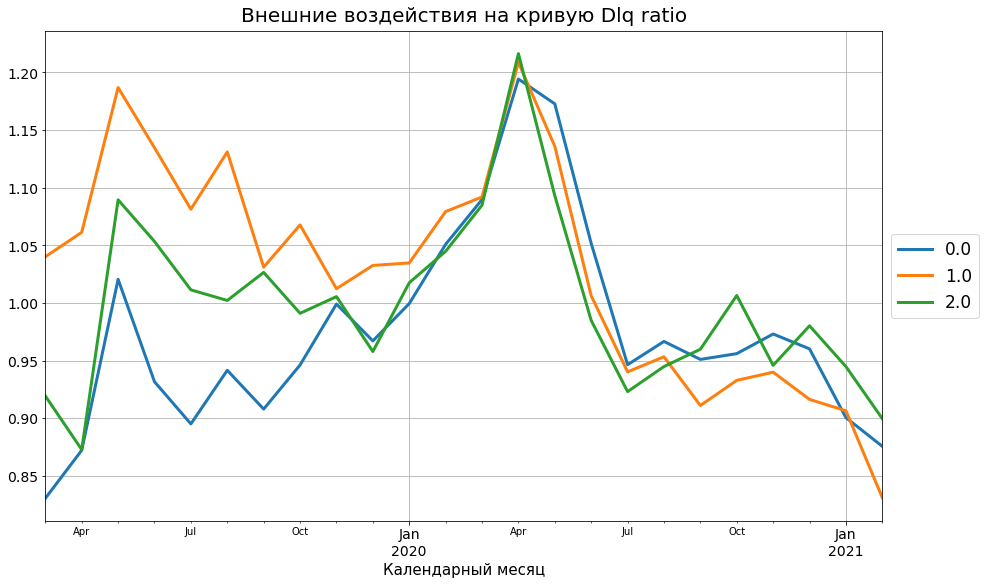

In [68]:
res['external_data'].set_index('month_dt')\
                    .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Внешние воздействия на кривую Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Календарный месяц", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

C:\Users\user\AppData\Local\Temp/ipykernel_13248/468277055.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  res['maturation_data'].drop('statement_num', 1).plot(ax=None, figsize=(15, 9), grid=True, lw = 3)


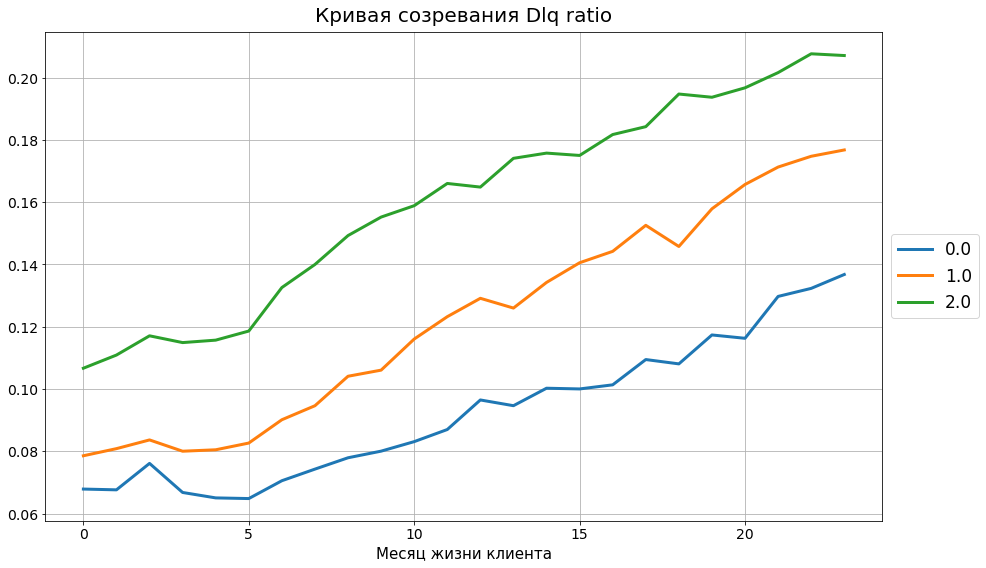

In [69]:
res['maturation_data'].drop('statement_num', 1).plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая созревания Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

In [70]:
dlq_ratio_mean = res['fitted_data'].groupby([ 'pd_bucket', 'statement_num'])\
    .agg({'fitted_feature':np.mean})\
    .rename(columns = {'fitted_feature':'Среднее'})

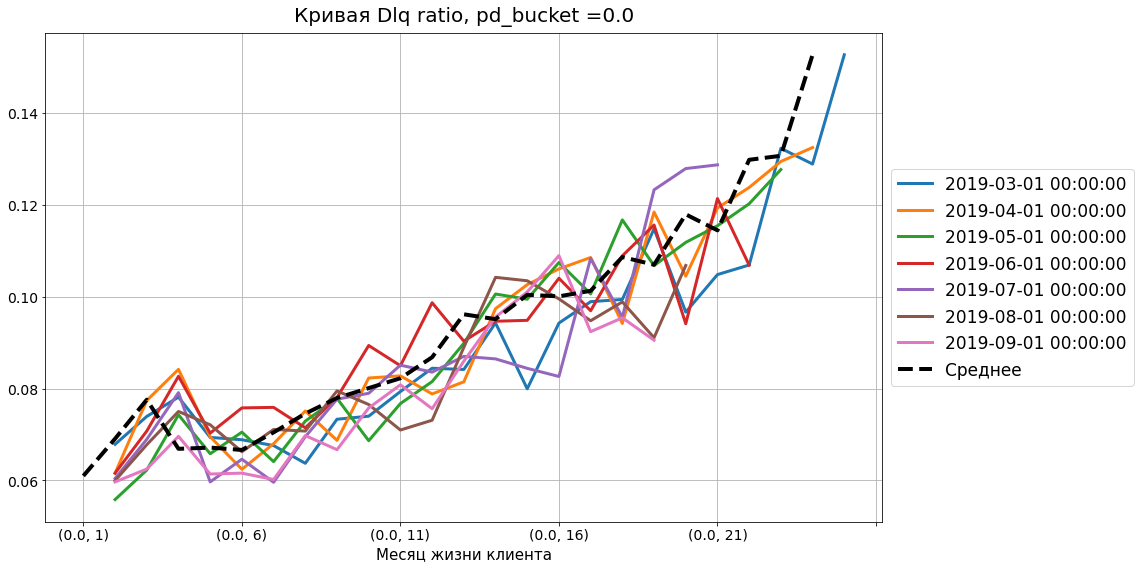

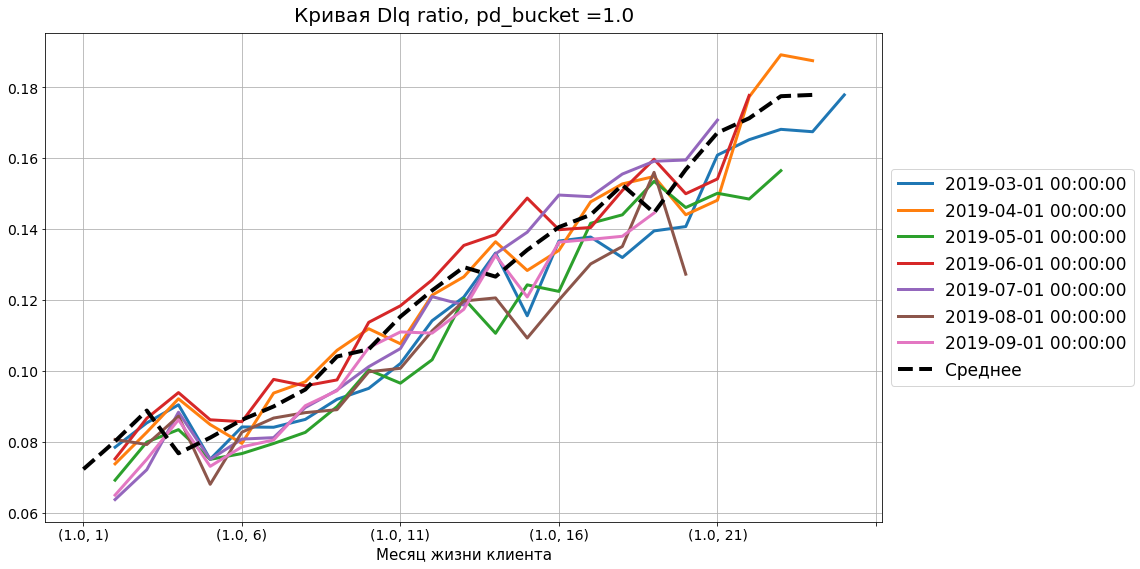

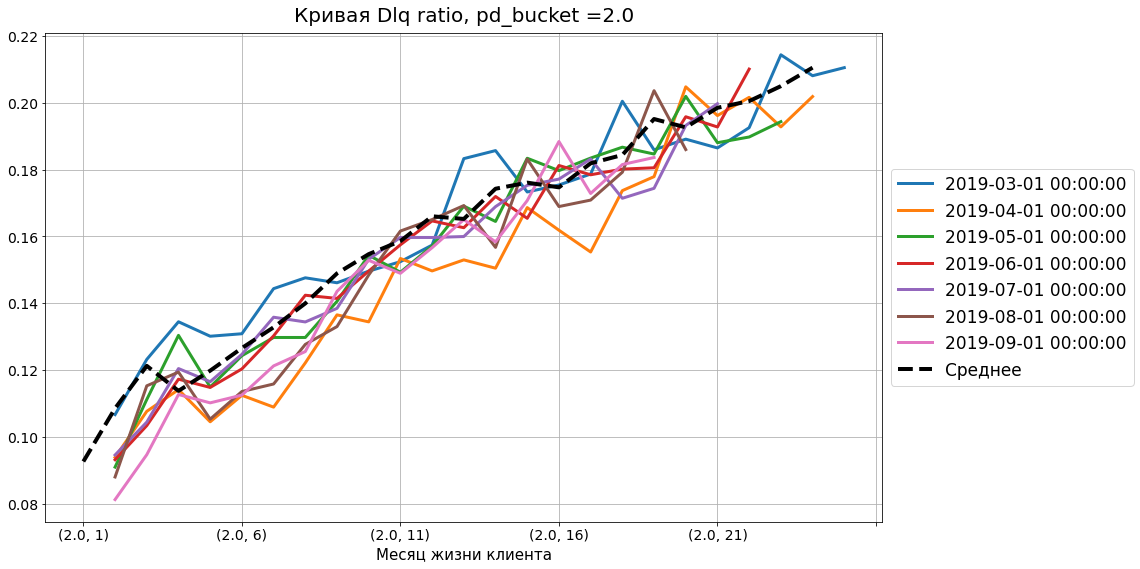

In [71]:
def plot_dlq_ratio_mean(pd_bucket):
    vintages_graph = res['fitted_data'].query('pd_bucket == ' + str(pd_bucket))\
            .groupby(["gen_month_dt", "statement_num"])\
            .agg({"fitted_feature":np.sum})\
            .unstack('gen_month_dt')\
            ['fitted_feature']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
    (dlq_ratio_mean.query('pd_bucket == ' + str(pd_bucket))['Среднее']
             .plot( figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    plt.title("Кривая Dlq ratio, pd_bucket =" + str(pd_bucket), "", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

for bucket in buckets:
    plot_dlq_ratio_mean(bucket)

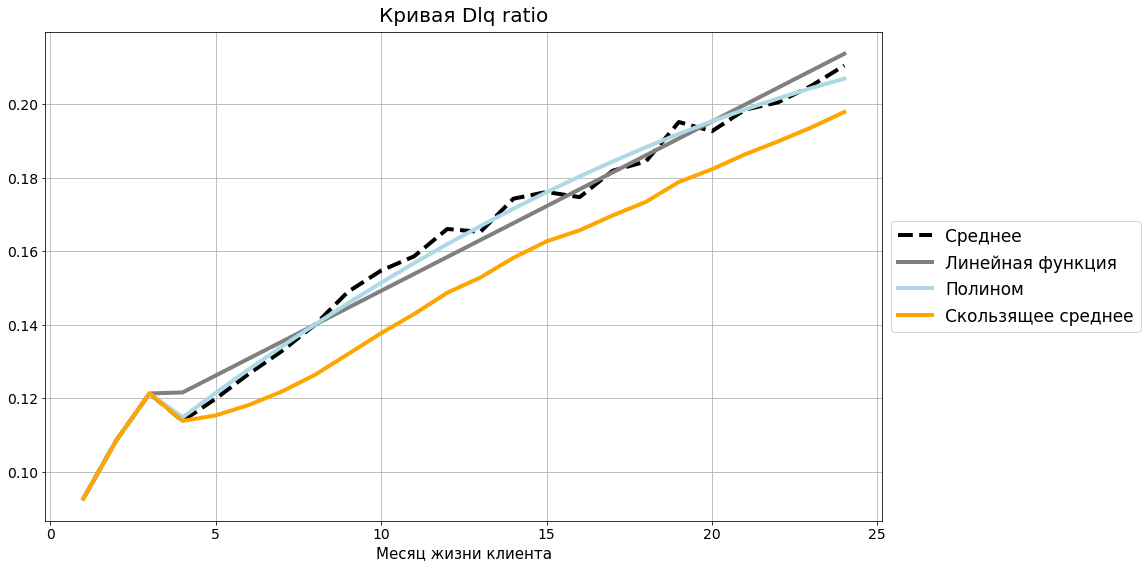

In [72]:
df_linear = dlq_ratio_mean.query('pd_bucket == 2').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 4, 24)
df_polynom = polynom_approximation(df_linear, 4,24,2)
df_smooth = exponential_smoothing(df_polynom, 4,24, 0.25)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_smooth['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_smooth['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth['Скользящее среднее'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Полином приближает лучше всех.

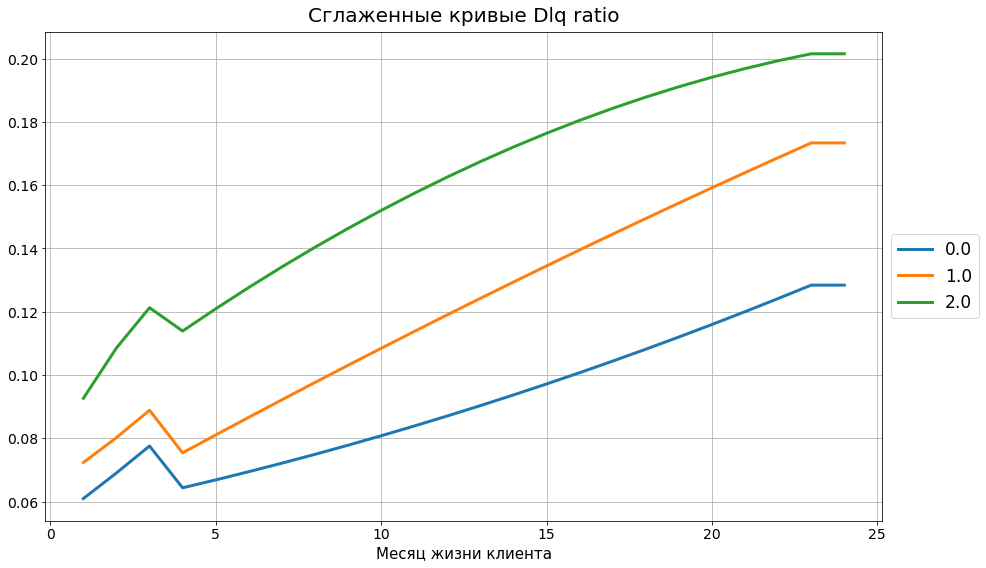

In [73]:
df_smooth_result = pd.DataFrame()

# Далем полиномиальное сглаживание для каждого бакета
for bucket in buckets:
    df_temp = dlq_ratio_mean.query('pd_bucket == ' + str(bucket)).reset_index().set_index(['statement_num'])
    df_smooth_result[str(bucket)] = polynom_approximation(df_temp, 4, 22, 2)['Полином']

# Строим итоговый график 
df_smooth_result.plot(figsize=(15, 9), grid=True, lw = 3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Сглаженные кривые Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)